In [2]:
import sys
import os
import math
import random
import heapq 
import numpy as np
import pandas as pd
from PIL import Image
import psycopg2 as ps
from io import StringIO,BytesIO 
import pywt
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
#create table and import images with Binary
conn = ps.connect(host="127.0.0.1", user="postgres", password="postgres", database="isee")#connect postgresql 
if conn is not None:
    cur = conn.cursor()
    #create table
    command = "create table isee_multi (name text NOT NULL, type text NOT NULL, content bytea NOT NULL);"#create table
    cur.execute(command)
    conn.commit()# commit the changes
    cur.close()# close communication with the PostgreSQL database server
conn.close()#close connect with database server

In [4]:
#insert images into table
conn = ps.connect(host="127.0.0.1", user="postgres", password="postgres", database="isee")#connect postgresql 
if conn is not None:
    cur = conn.cursor()
    #insert images
    root_dir = '/data/fjsdata/fundus/iSee/iSee_multi_dataset/' #the path of images
    for itype in ['AMD','DR','glaucoma','myopia','norm']: #AMD-720, DR-270, glaucoma-450,myopia-790,norm-7770,all-10000
        image_dir = root_dir+'img_data_%s'%itype
        for fname in sorted(os.listdir(image_dir)):
            if fname.endswith(".jpg"):
                with open(os.path.join(image_dir, fname),'rb') as reader:#open the image file 
                        img_buffer = reader.read()     
                command = "insert into isee_multi(name, type, content) values(%s, %s, %s);"#create table cataract
                params = (fname, itype, ps.Binary(img_buffer))
                cur.execute(command, params)
                conn.commit()# commit the changes  
    cur.close()# close communication with the PostgreSQL database server
conn.close()#close connect with database server

In [22]:
#evaluation
conn = ps.connect(host="127.0.0.1", user="postgres", password="postgres", database="isee")#connect postgresql 
if conn is not None:
    cur = conn.cursor() 
    #random choose test samples 10% AMD-720, DR-270, glaucoma-450,myopia-790,norm-7770,all-10000
    name_list = []
    for itype in ['AMD','DR','glaucoma','myopia','norm']:
        if itype=='AMD': num=72
        elif itype=='DR': num=27
        elif itype=='glaucoma': num=45
        elif itype=='myopia': num=79
        else: num =100
        command ="select name,type from isee_multi where type =%s order by random() limit %s;"
        params = (itype, num)
        cur.execute(command, params)
        for name ,itype in cur.fetchall():
            name_list.append((name,itype))
    #search similar images  and evaluation
    for topk in [5,10,15]:
        HR =[] #Hit ratio 
        MAP =[] #mean average precision
        for name,itype in name_list:
            command = "SELECT name, type, smlr FROM ( SELECT name, type, pattern <-> (SELECT pattern FROM isee_pat WHERE name = %s LIMIT 1) AS smlr FROM isee_pat WHERE name <> %s ORDER BY signature <-> (SELECT signature FROM isee_pat WHERE name = %s LIMIT 1) LIMIT 1000) x ORDER BY x.smlr ASC LIMIT %s;"
            params = (name, name, name, topk)
            cur.execute(command, params)
            #perfromance
            pos_len = 0
            rank_len = 0
            for tname, titype, smlr in cur.fetchall():
                rank_len=rank_len+1
                if titype==itype:  #hit
                    HR.append(1)
                    pos_len = pos_len +1
                    MAP.append(pos_len/rank_len) 
                else: 
                    HR.append(0)
                    MAP.append(0)   
        print("HR@{}={:.6f}, MAP@{}={:.6f}".format(topk,np.mean(HR),topk,np.mean(MAP)))              
    cur.close()
conn.close()

HR@5=0.315789, MAP@5=0.271940
HR@10=0.311146, MAP@10=0.250993
HR@15=0.306502, MAP@15=0.238948


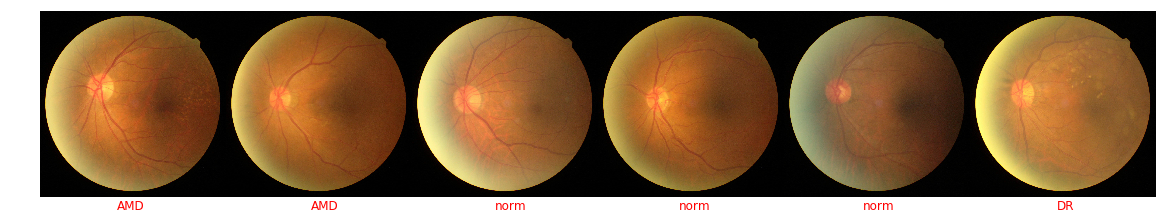

In [17]:
def image_joint(image_list,opt):#opt= vertical ,horizontal 选择水平显示拼接的图像，或者垂直拼接
    image_num=len(image_list)
    image_size=image_list[0].size
    height=image_size[1]
    width=image_size[0]
    
    if opt=='vertical':
        new_img=Image.new('RGB',(width,image_num*height),255)
    else:
        new_img=Image.new('RGB',(image_num*width,height),255)
    x=y=0
    count=0
    for img in image_list:
        
        new_img.paste(img,(x,y))
        count+=1
        if opt=='horizontal':
            x+=width
        else : y+=height
    return new_img
#get images
image_list = []
type_list =[]
AMD_name = '485156.jpg'
root_dir = '/data/fjsdata/fundus/iSee/iSee_multi_dataset/' #the path of images
image_list.append(Image.open(root_dir+'img_data_AMD/%s'%AMD_name))
type_list.append('AMD')
conn = ps.connect(host="127.0.0.1", user="postgres", password="postgres", database="isee")#connect postgresql 
if conn is not None:
    cur = conn.cursor() 
    command = "SELECT name, type, smlr FROM ( SELECT name, type, pattern <-> (SELECT pattern FROM isee_pat WHERE name = %s LIMIT 1) AS smlr FROM isee_pat WHERE name <> %s ORDER BY signature <-> (SELECT signature FROM isee_pat WHERE name = %s LIMIT 1) LIMIT 1000) x ORDER BY x.smlr ASC LIMIT 5;"
    params = (AMD_name, AMD_name, AMD_name)
    cur.execute(command, params)
    for tname, titype, smlr in cur.fetchall():
        #show
        image_dir = root_dir+'img_data_%s'%titype
        image_list.append(Image.open(root_dir+'img_data_%s/%s'%(titype,tname)))
        type_list.append(titype)
    cur.close()
conn.close()
AMD_image = image_joint(image_list,opt='horizontal')
#AMD_image.save('AMD_image.jpg')
plt.figure(figsize=(20, 20))
#plt.title('AMD',fontsize=12, color='b')
plt.axis('off')  # non-Axis of coordinates
plt.text(1000-200, 2050, r'%s'%type_list[0], fontsize=12 ,color='r')
plt.text(3000-200, 2050, r'%s'%type_list[1], fontsize=12 ,color='r')
plt.text(5000-300, 2050, r'%s'%type_list[2], fontsize=12 ,color='r')
plt.text(7000-400, 2050, r'%s'%type_list[3], fontsize=12 ,color='r')
plt.text(9000-500, 2050, r'%s'%type_list[4], fontsize=12 ,color='r')
plt.text(11000-500, 2050, r'%s'%type_list[5], fontsize=12 ,color='r')
plt.imshow(AMD_image)

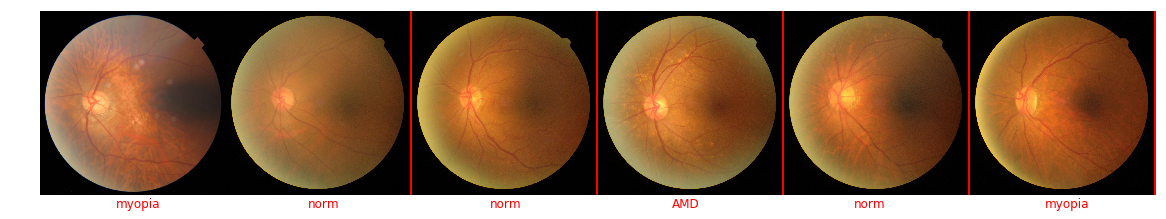

In [19]:
def image_joint(image_list,opt):#opt= vertical ,horizontal 选择水平显示拼接的图像，或者垂直拼接
    image_num=len(image_list)
    image_size=image_list[0].size
    height=image_size[1]
    width=image_size[0]
    
    if opt=='vertical':
        new_img=Image.new('RGB',(width,image_num*height),255)
    else:
        new_img=Image.new('RGB',(image_num*width,height),255)
    x=y=0
    count=0
    for img in image_list:
        
        new_img.paste(img,(x,y))
        count+=1
        if opt=='horizontal':
            x+=width
        else : y+=height
    return new_img
#get images
image_list = []
type_list =[]
query_name = '481294.jpg'
root_dir = '/data/fjsdata/fundus/iSee/iSee_multi_dataset/' #the path of images
image_list.append(Image.open(root_dir+'img_data_myopia/%s'%query_name))
type_list.append('myopia')
conn = ps.connect(host="127.0.0.1", user="postgres", password="postgres", database="isee")#connect postgresql 
if conn is not None:
    cur = conn.cursor() 
    command = "SELECT name, type, smlr FROM ( SELECT name, type, pattern <-> (SELECT pattern FROM isee_pat WHERE name = %s LIMIT 1) AS smlr FROM isee_pat WHERE name <> %s ORDER BY signature <-> (SELECT signature FROM isee_pat WHERE name = %s LIMIT 1) LIMIT 1000) x ORDER BY x.smlr ASC LIMIT 5;"
    params = (query_name, query_name, query_name)
    cur.execute(command, params)
    for tname, titype, smlr in cur.fetchall():
        #show
        image_dir = root_dir+'img_data_%s'%titype
        image_list.append(Image.open(root_dir+'img_data_%s/%s'%(titype,tname)))
        type_list.append(titype)
    cur.close()
conn.close()
big_image = image_joint(image_list,opt='horizontal')
plt.figure(figsize=(20, 20))
#plt.title('AMD',fontsize=12, color='b')
plt.axis('off')  # non-Axis of coordinates
plt.text(1000-200, 2050, r'%s'%type_list[0], fontsize=12 ,color='r')
plt.text(3000-200, 2050, r'%s'%type_list[1], fontsize=12 ,color='r')
plt.text(5000-300, 2050, r'%s'%type_list[2], fontsize=12 ,color='r')
plt.text(7000-400, 2050, r'%s'%type_list[3], fontsize=12 ,color='r')
plt.text(9000-500, 2050, r'%s'%type_list[4], fontsize=12 ,color='r')
plt.text(11000-500, 2050, r'%s'%type_list[5], fontsize=12 ,color='r')
plt.imshow(big_image)

In [32]:
def image_joint(image_list,opt):#opt= vertical ,horizontal 选择水平显示拼接的图像，或者垂直拼接
    image_num=len(image_list)
    image_size=image_list[0].size
    height=image_size[1]
    width=image_size[0]
    
    if opt=='vertical':
        new_img=Image.new('RGB',(width,image_num*height),'white')
    else:
        new_img=Image.new('RGB',(image_num*width,height),'white')
    x=y=0
    count=0
    for img in image_list:
        
        new_img.paste(img,(x,y))
        count+=1
        if opt=='horizontal':
            x+=width
        else : y+=height
    return new_img

image_list=[]
image_list.append(Image.open("/data/tmpexec/glaucoma.png"))
image_list.append(Image.open("/data/tmpexec/myopia.png"))
image_list.append(Image.open("/data/tmpexec/AMD.png"))
image_list.append(Image.open("/data/tmpexec/DR.png"))
image_joint(image_list,opt='horizontal').save('isee.png')